In [1]:
import laspy as lp
import numpy as np

import pyvista as pv 
import pyransac3d as pyrsc

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

def get_points_and_colors_from_las(las_path: str, limit: int = -1):
    if not isinstance(las_path, str):
        raise ValueError("las_path must be a string.")
    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    las = read_las_file(las_path)
    if las is None:
        raise ValueError("No valid LAS file found.")

    points = np.vstack((las.x, las.y, las.z)).transpose()
    colors = np.vstack((las.red, las.green, las.blue)).transpose()

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]

    rgba_colors = normalize_colors(colors)
    return points, colors, rgba_colors, np.expand_dims(las.classification, -1)

In [31]:
POOL_NAME = 'RBN'
PROJECT_NAME = '250111_Pools_100kHz_120m'
PATH_PROJECT_LAS = f'data/{PROJECT_NAME}/{POOL_NAME}_clasificada_col_0_row_0_19s.las'
LIMIT = -1

In [ ]:
las_points, las_colors, las_rgba_colors, las_clasification = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(las_points[:,:3])

las_data_points = np.hstack((las_points_norm, las_rgba_colors, las_clasification))

other_points = las_data_points[las_data_points[:,-1] != 65]
water_points = las_data_points[las_data_points[:,-1] == 65]

plane = pyrsc.Plane()
best_eq, best_inliers = plane.fit(water_points[:,:3], 0.01)
A, B, C, D  = best_eq 
print(f"Ecuación del plano: {A}x + {B}y + {C}z + {D} = 0")

delta = 0.05
X = other_points[:, 0]
Y = other_points[:, 1]
Z = other_points[:, 2]

# Calcular la distancia de cada punto al plano
distances = (A * X + B * Y + C * Z + D) / np.sqrt(A**2 + B**2 + C**2)

# Crear una malla de puntos para el plano
xx, yy = np.meshgrid(np.linspace(X.min(), X.max(), 10), np.linspace(Y.min(), Y.max(), 10))
zz = (-A * xx - B * yy - D) / C

# # Crear una superficie para el plano
plane = pv.StructuredGrid(xx, yy, zz)

# # Crear un plotter de PyVista
plotter = pv.Plotter()

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -delta
above_plane = distances >= delta

water_points_pv = pv.PolyData(water_points[:,:3])
plotter.add_points(water_points_pv, color='yellow', point_size=5)

# # Añadir los puntos por debajo del plano en verde
points_below = pv.PolyData(np.column_stack((X[below_plane], Y[below_plane], Z[below_plane])))
plotter.add_points(points_below, color='green', point_size=5)

# # Añadir los puntos por encima del plano en rojo
points_above = pv.PolyData(np.column_stack((X[above_plane], Y[above_plane], Z[above_plane])))
plotter.add_points(points_above, color='red', point_size=5)

# # Añadir la superficie del plano al plotter
plotter.add_mesh(plane, color='blue', opacity=0.5)

# # Mostrar el plotter
plotter.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1056926 but size of corresponding boolean axis is 11593

In [28]:
import matplotlib.pyplot as plt

x = X[below_plane] 
y = Y[below_plane] 
p99 = np.percentile(water_points[:,2], 99)

print(p99)
z = (p99 - Z[below_plane]) 

np.mean(z)


2345.2485


np.float64(0.8200935549242799)

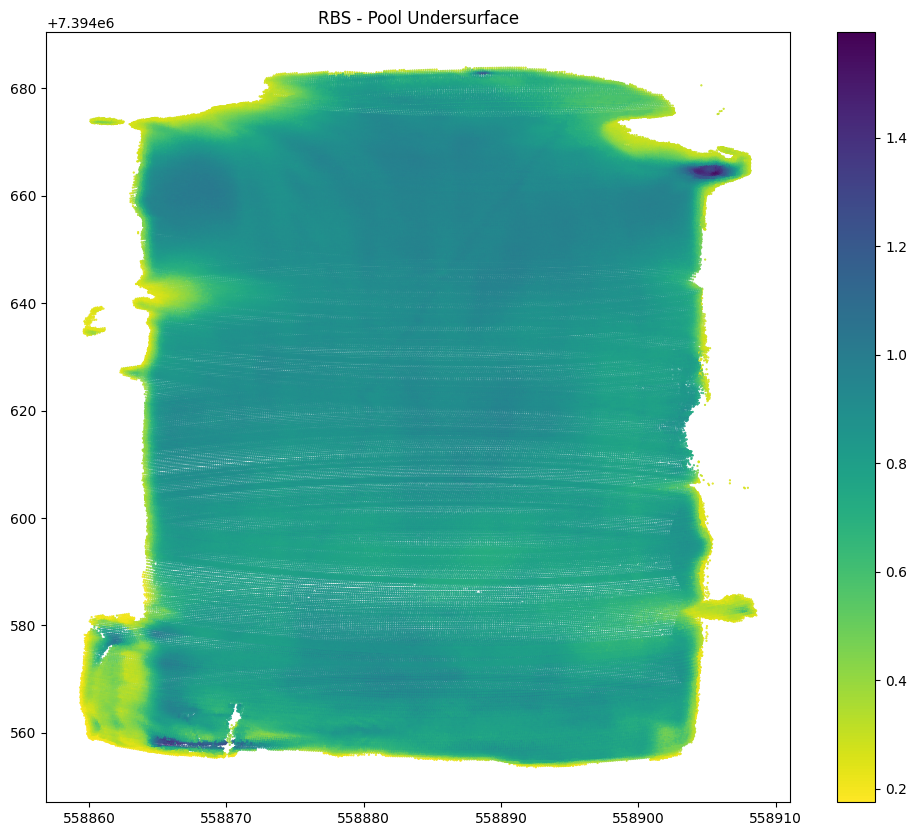

In [30]:
plt.figure(figsize=(12, 10)) 
plt.title('RBS - Pool Undersurface')
plt.scatter(x, y, c=z, cmap='viridis_r', s=0.3)
plt.colorbar()
plt.savefig('img.png', dpi=300)
plt.show()

In [ ]:
import cv2
import os
from PIL import Image

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = z.astype(np.float32) 
cv2.imwrite(f'{POOL_NAME}_z_model2.exr', z_save)

#pil_image_z = Image.fromarray(z_save)
#pil_image_z.save(f'{POOL_NAME}_z_model2.tiff')





NameError: name 'rgb' is not defined